In [947]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

import numpy as np
import math
import pandas as pd
import itertools

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 30)
#pd.options.display.float_format = '{:,}'.format 



In [948]:
def enum_category(label):
    num=0
    if label == 'Poor' : num =1
    elif label == 'Fair': num = 2
    elif label == 'Average': num = 3
    elif label == 'Good': num = 4
    elif label == 'Very Good': num = 5
    else: return label
    
    return int(num)

def log_and_normalize (data, log, norm_type):
    if log == 'log':
        data = np.log(data) 
    if norm_type == 1:
        data = (data-np.mean(data))/np.std(data)  # std normalisation
    elif norm_type == 2:
        data = (data-min(data))/(max(data)-min(data))      #  min_max_min
    elif norm_type == 3:
        data = (data-np.mean(data))/(max(data)-min(data))  # mean norm
    
    return data    

def hot_encode (data, directions):
    if directions == 'yes':
        data = pd.get_dummies(data, prefix=data.name[:3], drop_first=True)
    return data

In [967]:
df=pd.read_csv('data/kc_house_data.csv', index_col=0)

# initial cleaning operations (dropping columns, splitting , etc)
df.drop(columns=["waterfront",'view'],inplace=True)
df["grade"]=df["grade"].map(lambda x: x.split()[0]).astype(int)
df['condition'] = df['condition'].apply(enum_category)

#FILTER
#df=df[df['yr_built']>1961]
None



In [999]:
# Prepairing data
df.groupby('yr_renovated')['yr_renovated','yr_built'].count()

df.drop(df.index[df["bedrooms"]==33], inplace=True)

df['renovated']=np.where((df['yr_renovated'].isna() |  df['yr_renovated'] == 0), 0, 1)
df['yr_renovated'].fillna(value=df['yr_built'],inplace=True)
df['yr_renovated'] = np.where(df['yr_renovated'] == 0, df['yr_built'], df['yr_renovated'])

df['sqft_basement'].replace('?', '-1', inplace=True)
df['sqft_basement']=df['sqft_basement'].astype(float).astype(int)

df['sqft_basement'] = np.where((df['sqft_basement'] < 100) & (df['sqft_basement'] > 0), 0, df['sqft_basement'])
df['sqft_basement']=np.where((df['sqft_basement']==-1) & (df['sqft_living']-df['sqft_above']<=400), 
                             0, df['sqft_basement'])
df['sqft_basement']=np.where((df['sqft_basement']==-1) & (df['sqft_living']-df['sqft_above']>400) 
                             & (df['sqft_above']/df['sqft_living']<0.70),
                             (df['sqft_living']-df['sqft_above'])*0.75/df['floors'], df['sqft_basement'])
df['sqft_basement'] = np.where (df['sqft_basement'] == -1, 0, df['sqft_basement'])



#NEW FEATURES

df["age"]=2016-df['yr_built']
df["years_after_renovation"]=2016-df['yr_renovated']




In [1010]:
cont=["sqft_living",'lat', 'yr_built']
cont=["sqft_living"]
#cont=["sqft_living",  'sqft_living15', 'sqft_lot15', 'lat']

cat=[ 'grade']
#cat=[ "grade",  'bedrooms',  'floors', 'condition','yr_built' ]

data_fin=pd.DataFrame([])
price=df[["price"]]
#num=df.select_dtypes(include=[np.number]).drop("price", axis=1)

In [1011]:
# Log transform and normalize
for col in cont:
    data_fin[col]=log_and_normalize(df[col], 'nolog', 0)

#data_fin["sqft_living"]=log_and_normalize(df["sqft_living"], 'log', 0)
#data_fin["lat"]=log_and_normalize(df["lat"], 'nolog', 0)
#data_fin["yr_built"]=log_and_normalize(df["yr_built"], 'nolog', 0)
price=log_and_normalize(df["price"], 'nolog', 0)

In [1012]:
# One hot encode categoricals
for col in cat:
    new_cols=hot_encode(df[col], 'yes')
    data_fin = pd.concat([data_fin, new_cols], axis=1)


In [1013]:
data_fin = pd.concat([price, data_fin], axis=1)


In [1014]:
pd.options.display.float_format = '{:,}'.format 

pred=data_fin.drop(columns=["price"]).copy()



pred_int = sm.add_constant(pred)
model = sm.OLS(price,pred_int).fit()
model.params





const          180,229.54893300688
sqft_living     157.25086743652784
gra_4          -75,274.76906202121
gra_5          -86,334.51450958967
gra_6          -65,687.03175175004
gra_7          -43,340.34077110216
gra_8          19,194.985484563746
gra_9           142,491.1763307398
gra_10          338,547.7175361569
gra_11          626,374.7210010701
gra_12         1,160,717.504542537
gra_13        2,353,819.3445881126
dtype: float64

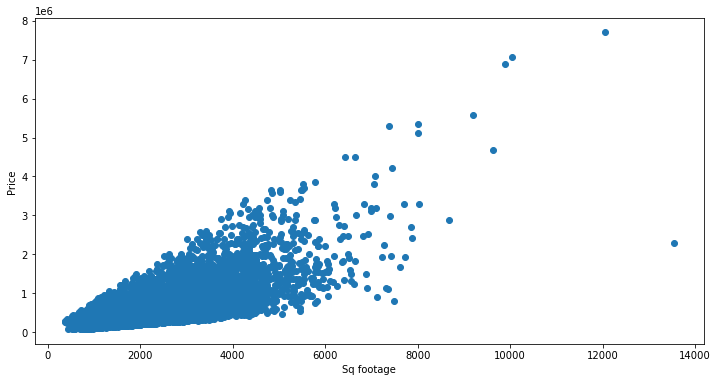

In [989]:
sales_pred = model.predict()
sales_pred
plt.figure(figsize=(12, 6))
plt.plot(df['sqft_living'], df['price'], 'o')  
#plt.plot(pred_int['sqft_living'], sales_pred, 'r', linewidth=2)
plt.xlabel('Sq footage')
plt.ylabel('Price')
plt.show()

In [590]:
results=[]
combs=data_fin.drop("price", axis=1).columns
#combs=num
for comb in itertools.combinations(combs, 1):
    test=data_fin[list(comb)].copy()
    prep = sm.add_constant(test[list(comb)])
    model = sm.OLS(price, prep).fit()
    results.append([comb, model.rsquared_adj])

pd.DataFrame(results).sort_values(1, ascending=False)



,0,1
0,"(sqft_living,)",0.48329173419094196
4,"(gra_7,)",0.11481198045266239
7,"(gra_10,)",0.11384937523653094
6,"(gra_9,)",0.0958221369573512
3,"(gra_6,)",0.09557742383049794
8,"(gra_11,)",0.07968480899008434
9,"(gra_12,)",0.032052595211412016
2,"(gra_5,)",0.021431669881383897
5,"(gra_8,)",0.01086820828788515
10,"(gra_13,)",0.008471124546015063


In [754]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(pred,price)
linreg.score(pred, price)

0.7778779726116771

In [783]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

pred_train, pred_test, price_train, price_test = train_test_split(pred, price, test_size=0.2)

In [784]:
linreg = LinearRegression()
linreg.fit(pred_train, price_train)
linreg.score(pred_train, price_train)

0.776782494188267

In [785]:
y_train = linreg.predict(pred_train)
y_test = linreg.predict(pred_test)

In [786]:
train_residuals = y_train - price_train
test_residuals = y_test - price_test

In [787]:
mse_train = np.sum((price_train-y_train)**2)/len(price_train)
mse_test = np.sum((price_test-y_test)**2)/len(price_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: 0.05855477965607087
Test Mean Squarred Error: 0.05656099812861376


In [774]:
mse_train

0.059097189385764415

In [777]:
train_mse = mean_squared_error(price_train, y_train)
test_mse = mean_squared_error(price_test, y_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 0.059097189385764415
Test Mean Squarred Error: 0.05440668311324934
